<a id='Jump'></a>
## [Feature Selection](#Feature_Selection) <br>

---

## Models
- #### [Random Forest Train](#Random_Forest) (**Deprecated**)
- #### [XGB Train Model](#XGB_train) [Try Grid search](#Try_grid_search) (**Deprecated**)
- #### [GBRegressor Train](#GBRegressor_train) (**Deprecated**)
- #### [CatBoost train](#CatBoosttrain) (**Used**)

---

### [Model Prediction](#Model_Prediction)
### [Save Submission](#Save_Submission)

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

In [2]:
#model selction tools
from sklearn.model_selection import train_test_split , GridSearchCV\
        , StratifiedKFold , TimeSeriesSplit,KFold,cross_val_score
#metrics 
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
#models 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor,BaggingRegressor,GradientBoostingRegressor
import xgboost as xgb
import catboost as cb
#tools
from sklearn.inspection import permutation_importance
from sklearn.utils import shuffle
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline


<a id='path'></a>
### loading data
##### [Jump Top](#Jump)

In [3]:
### loading data
##### [Jump Top](#Jump)#---------- configs
pd.set_option('max_rows',100)
pd.set_option('max_columns',40)

In [4]:
train_path = r"../input/seoul-bike-rental-ai-pro-iti/train.csv"
test_path = r"../input/seoul-bike-rental-ai-pro-iti/test.csv"

In [5]:
df = pd.read_csv(train_path,index_col=0,parse_dates=['Date'],dayfirst=True)
df_test = pd.read_csv(test_path,parse_dates=['Date'],dayfirst=True)

df = df.rename(columns={'Temperature(�C)':'Temperature(C)'
                        ,'Dew point temperature(�C)'  : 'Dew point temperature(C)'})

df_test = df_test.rename(columns={'Temperature(�C)':'Temperature(C)'
                                  ,'Dew point temperature(�C)'  : 'Dew point temperature(C)'})

## Feature Engineering

##### based on the previous notebook (EDA) we will consider the following 

- A) The Hourly cycle has a good correlation. [7am-18pm has the bigger share]
- B) The Temperature has good corr. [high is good except > ~ 27]
- C) The Functional Day has good corr. [functional is good for target]
- D) The Seasons has good corr. [hot season is better]

-------------

- E) The Visibility may prove to be good. [if encoded to very_low visibility vs normal visibiliy].
- F) The RainFall/SnowFall may prove to be good. [if encoded to Snowing / Raining or not].
- G) The Humidity may have something to investigate. [if encoded as 0-80 % normal rentals, 80-100% show sharp decay in rentals]

---------------
- H) the Dew point temperature is strongly corr to Temperature will drop it, if using a linear model.
- I) the Solar Radiation may be discarded .. i didn't see good relation. if using a linear model also.
- J) the holidays didn't prove decisive saying on our target. maybe discarded too.
-----

- **In order to get more features that may help the model understanding relationships among variables, we tended to collect our domain knowledge about the problem, and gathered most of it through searching, thinking, and visualizing. Clustering Weather-State, Sky-State, Day-Night & more, came along from this Point.**

- getting the rush hour and Dead Hours of our DF

In [6]:
def rush_hour(df):
    #from 8 am , 6 pm
    rush_range_1 = 2 # around the rush hour by +- 2 hrs
    rush_range_2 = 5 # around the rush hour by +- 4 hrs
    is_functional = df['Functioning Day'] 
    
    if (abs(df['Hour'] - 8) <= rush_range_1): 
        return np.exp(-abs(df['Hour'] - 8)) * is_functional
    
    elif (abs(df['Hour'] - 18) <= rush_range_2):
        return np.exp(-abs(df['Hour'] - 18)) * is_functional
    else:
        return 0
        
def dead_hour(df):
    #dead_range_1 = 5 # around the dead hour by +- 3 hrs from 4 am
    is_functional = df['Functioning Day'] 
    
    if(df['Hour'] in [22,23,0,1,2,3,4,5]):
        return np.exp(-abs(df['Hour'] - 4)) * is_functional
    else:
        return 0 

- getting The state of the Day , night or morning

In [7]:
day_state = lambda df : 1  if (df['Hour'] >=6 and df['Hour'] <=18) else 0

#### Using The Temp column to create Humidex 
[Source](https://en.wikipedia.org/wiki/Humidex)
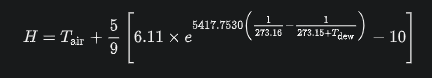

In [8]:
humidex = lambda df : df['Temperature(C)'] + (5/9) *\
(6.11 * np.exp(5417.7530 * (1/273.16-(1/(273.15 + df['Dew point temperature(C)']) ) ) ) -10)

# get the high Humidity 
Humidity_high = lambda df : 0 if (df['Humidity(%)'] <= 70) else 1

- Visibility Clustering into classes.

In [9]:
#To change 
#remove unsed
def visibility(df):
    #0:250 , 250:500 : 500:inf
    
    if df['Visibility (10m)'] <=250 :
        return 0
    elif df['Visibility (10m)'] <=350 :
        return 1
    elif df['Visibility (10m)'] <=450 :
        return 1
    elif df['Visibility (10m)'] <=550 :
        return 2
    elif df['Visibility (10m)'] <=650 :
        return 2
    elif df['Visibility (10m)'] <=850 :
        return 3
    elif df['Visibility (10m)'] <=1150 :
        return 3
    elif df['Visibility (10m)'] <=1350 :
        return 4
    else:
        return 5
#To change 
#visibility_dist:visibility_Status
def visibility_dist(df):
    #0:250 , 250:500 : 500:inf
    
    if df['Visibility (10m)'] <100 :     #can't see
        return 1
    elif df['Visibility (10m)'] <400 :   # foggy
        return 2
    elif df['Visibility (10m)'] <1000 :  # low fog
        return 3
    elif df['Visibility (10m)'] <2000 :  # no fog (good vision)
        return 4
    elif df['Visibility (10m)'] <4000 :  # no fog (excellent vision)
        return 5
    else:
        return 5

#### Rain
- creating a feature to see Sky state (Rain And SnowFall ) to conclude if it rains, snows or not.

In [10]:
rain_fall = lambda df : 0 if df['Rainfall(mm)'] < 0.5 else 1
snow_fall = lambda df : 0 if df['Snowfall (cm)'] == 0 else 1

In [11]:
Bad_Weather = lambda df :0 \
if (df['Temperature(C)'] < 35) and (df['Humidity(%)'] < 70) and (df['Solar Radiation (MJ/m2)'] < 1.4) \
else 1

High_temperature = lambda df : 0 if (df['Temperature(C)'] <= 35) else 1


Ideal = lambda df: 1 if (df['Temperature(C)'] < 30 and df['Wind speed (m/s)'] < 2.8) else 0

- Manually Putting the Weather State

In [12]:
def Sunny_Hot (df):
    if ((df['Temperature(C)']>25)&((df['Solar Radiation (MJ/m2)'] >2)&(df['day_night']==1))):
        return True
    else:
        return False

def Clear_hot (df):
    if ((df['Temperature(C)']>25)&(((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1))\
                                   &(df['day_night']==1))&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def PCloudy_hot(df):  
    if((df['Temperature(C)']>25)&(((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5))\
                                                       &(df['day_night']==1))&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
    
def Cloudy_hot(df): 
    if((df['Temperature(C)']>25)&(((df['Solar Radiation (MJ/m2)'] <=0.5))&(df['day_night']==1))\
                      &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Rain_hot(df):  
    if((df['Temperature(C)']>25)&(df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def Night_hot(df): 
    if((df['Temperature(C)']>25)&(df['day_night']==0)
                      &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
    
def Sunny_Warm (df):
    if (((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))&((df['Solar Radiation (MJ/m2)'] >2)&(df['day_night']==1))):
        return True
    else:
        return False

def Clear_Warm (df):
    if (((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))\
        &(((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1))&(df['day_night']==1))\
        &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def PCloudy_Warm(df):  
    if(((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))\
       &(((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5))&(df['day_night']==1))\
       &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
    
def Cloudy_Warm(df): 
    if(((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))\
       &(((df['Solar Radiation (MJ/m2)'] <=0.5))&(df['day_night']==1))\
       &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
    
def Rain_Warm(df):  
    if(((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))&(df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def Night_Warm(df): 
    if(((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))\
       &(df['day_night']==0)&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
    
def Sunny_Cold (df):
    if (((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))&((df['Solar Radiation (MJ/m2)'] >2)&(df['day_night']==1))):
        return True
    else:
        return False

def Clear_Cold (df):
    if (((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))\
        &(((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1))&(df['day_night']==1))\
        &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def PCloudy_Cold(df):  
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))\
       &(((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5))&(df['day_night']==1))\
       &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
    
def Cloudy_Cold(df): 
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))\
       &(((df['Solar Radiation (MJ/m2)'] <=0.5))&(df['day_night']==1))\
       &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
    
def Rain_Cold(df):  
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))&(df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
    
def Snow_Cold(df):  
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))&(df['Rainfall(mm)'] ==0)&(df['Snowfall (cm)'] >0)):
        return True
    else:
        return False
    
def Night_Cold(df): 
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))\
       &(df['day_night']==0)&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
    
def Sunny_Freezing (df):
    if ((df['Temperature(C)']<=0)&((df['Solar Radiation (MJ/m2)'] >2)&(df['day_night']==1))):
        return True
    else:
        return False

def Clear_Freezing (df):
    if ((df['Temperature(C)']<=0)&(((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1))\
                                   &(df['day_night']==1))&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def PCloudy_Freezing(df):  
    if((df['Temperature(C)']<=0)&(((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5))\
                                                       &(df['day_night']==1))&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
    
def Cloudy_Freezing(df): 
    if((df['Temperature(C)']<=0)&(((df['Solar Radiation (MJ/m2)'] <=0.5))&(df['day_night']==1))\
                      &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
    
def Rain_Freezing(df):  
    if((df['Temperature(C)']<=0)&(df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
    
def Snow_Freezing(df):  
    if((df['Temperature(C)']<=0)&(df['Rainfall(mm)'] ==0)&(df['Snowfall (cm)'] >0)):
        return True
    else:
        return False

def Night_Freezing(df): 
    if((df['Temperature(C)']<=0)&(df['day_night']==0)
                      &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
    
def Rain_Snow(df):
    if (df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] >0):
        return True
    else:
        return False

In [13]:
Weather_State = lambda df:\
                "Sunny_hot" if Sunny_Hot(df)\
           else "Clear_hot" if Clear_hot(df)\
           else "PCloudy_hot" if PCloudy_hot(df)\
           else "Cloudy_hot" if Cloudy_hot(df)\
           else "Rain_hot" if Rain_hot(df)\
           else "Night_hot" if Night_hot(df)\
           else "Sunny_Warm" if Sunny_Warm(df)\
           else "Clear_Warm" if Clear_Warm(df)\
           else "PCloudy_Warm" if PCloudy_Warm(df)\
           else "Cloudy_Warm" if Cloudy_Warm(df)\
           else "Rain_Warm" if Rain_Warm(df)\
           else "Night_Warm" if Night_Warm(df)\
           else "Sunny_Cold" if Sunny_Cold(df)\
           else "Clear_Cold" if Clear_Cold(df)\
           else "PCloudy_Cold" if PCloudy_Cold(df)\
           else "Cloudy_Cold" if Cloudy_Cold(df)\
           else "Rain_Cold" if Rain_Cold(df)\
           else "Snow_Cold" if Snow_Cold(df)\
           else "Night_Cold" if Night_Cold(df)\
           else "Sunny_Freezing" if Sunny_Freezing(df)\
           else "Clear_Freezing" if Clear_Freezing(df)\
           else "PCloudy_Freezing" if PCloudy_Freezing(df)\
           else "Cloudy_Freezing" if Cloudy_Freezing(df)\
           else "Rain_Freezing" if Rain_Freezing(df)\
           else "Snow_Freezing" if Snow_Freezing(df)\
           else "Night_Freezing" if Night_Freezing(df)\
           else "Rain&Snow" if Rain_Snow(df)\
           else 0

Weather_Description_list = ['Night_Freezing', 'Cloudy_Freezing', 'PCloudy_Freezing',
                            'Clear_Cold', 'PCloudy_Cold', 'Cloudy_Cold', 'Night_Cold',
                            'Rain_Cold', 'Clear_Freezing', 'Rain&Snow', 'Snow_Freezing',
                            'Snow_Cold', 'Sunny_Freezing', 'Sunny_Cold', 'Sunny_Warm',
                            'Clear_Warm', 'PCloudy_Warm', 'Cloudy_Warm', 'Night_Warm',
                            'Rain_Warm', 'Sunny_hot', 'Clear_hot', 'Cloudy_hot', 'Night_hot',
                            'PCloudy_hot', 'Rain_hot']


length = len(Weather_Description_list) + 1
Weather_Description_neumeric = [*range(1, length, 1)]

- Manually Putting the Sky State

In [14]:
def Clear(df):
    if (df['Solar Radiation (MJ/m2)'] >2) & (df['day_night'] ==1):
        return 1
    else:
        return 0
    
def Few_Clouds(df):
    if (((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1.5)) & (df['day_night'] ==1)):
        return 1  
    else:
        return 0
    
def Scatterd_Clouds(df):
    if (((df['Solar Radiation (MJ/m2)'] <=1.5)&(df['Solar Radiation (MJ/m2)'] >1)) & (df['day_night'] ==1)):
        return 1  
    else:
        return 0
    
def Partly_Cloudy(df):
    if (((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5)) & (df['day_night'] ==1)):
        return 1  
    else:
        return 0
    
def Cloudy(df):
    if ((df['Solar Radiation (MJ/m2)'] <= 0.5) & (df['day_night'] ==1)):
        return 1
    else:
        return 0
    
def Night(df):
    if ((df['Solar Radiation (MJ/m2)'] <= 0.8) & (df['day_night'] ==0)):
        return 1
    else:
        return 0
    
# mist and fog 
def Mist(df):
    if df['Visibility_dist'] == 3:
        return 1
    else:
        return 0
    
def Fog(df):
    if ((df['Visibility_dist'] == 1) | (df['Visibility_dist'] == 2)) :
        return 1
    else:
        return 0
    
#Rain State 
def Light_Rain(df):
    if ((df['Rainfall(mm)']) >0 & (df['Rainfall(mm)'] < 2.5))  :
        return 1
    else:
        return 0
    
def Heavy_Rain(df):
    if (df['Rainfall(mm)'] >= 2.5)  :
        return 1
    else:
        return 0
    
def Ice_pallets(df):
        if ((df['Rainfall(mm)'] > 0 )& (df['Snowfall (cm)'] > 0 ))  :
            return 1
        else:
            return 0
#Snow State
def Light_Snow(df):
    if ((df['Snowfall (cm)']) >0 & (df['Snowfall (cm)'] < 1))  :
        return 1
    else:
        return 0
    
def Snow(df):
    if (df['Snowfall (cm)'] >= 1)  :
        return 1
    else:
        return 0

- Clustering Sky States into 5 classes

In [15]:
def Cond1(df):
    if Clear(df) or Few_Clouds(df) or Partly_Cloudy(df) or Cloudy(df):
        return 1
    else:
        return 0
    
def Cond2(df):
    if (Mist(df) and Cloudy(df)) or (Mist(df) and Partly_Cloudy(df)) or (Mist(df) and Few_Clouds(df)) or Mist(df):
        return 1
    else:
        return 0
    
def Cond3(df):
    if Light_Snow(df) or (Light_Rain(df) and Scatterd_Clouds(df)) or Light_Rain(df):
        return 1
    else:
        return 0
    
def Cond4(df):
    if (Ice_pallets(df) and Mist(df)) or (Snow(df) and Fog(df)) or Snow(df) :
        return 1
    else:
        return 0
    
def Cond5(df):
    if Night(df):
        return 1
    else:
        return 0
    
Sky_State = lambda df: 4 if Cond4(df)\
                 else 2 if Cond2(df)\
                 else 3 if Cond3(df)\
                 else 1 if Cond1(df)\
                 else 5

- Clustering the Temperature State

In [16]:
def Hot(df):
    if (df['Temperature(C)']>25):
        return 1
    else:
        return 0
    
def Warm(df):
    if ((df['Temperature(C)']<=25)&(df['Temperature(C)']>10)):
        return 1
    else:
        return 0
    
def Cold(df):
    if ((df['Temperature(C)']<=10)&(df['Temperature(C)']>0)):
        return 1
    else:
        return 0
    
def Freezing(df):
    if (df['Temperature(C)']<=0):
        return 1
    else:
        return 0
    
Temp_State = lambda df: 1 if Warm(df)\
                 else 2 if Cold(df)\
                 else 3 if Hot(df)\
                 else 4 if Freezing(df)\
                 else 5

---
<center> <h2> FEATURE ENGINEERING CLASS </h2> </center>

In [17]:
class FeatureEngineering:
    
    def __init__(self,df):
        self.original_df = df
        self.TransformedDF = self.original_df.copy()
    
    def get_date_attributes(self,Date_Col_name):        
        self.TransformedDF['Year'] = self.original_df[Date_Col_name].dt.year.astype('int')
        self.TransformedDF['Week'] = self.original_df[Date_Col_name].dt.isocalendar().week.astype('int')
        self.TransformedDF['Month'] = self.original_df[Date_Col_name].dt.month.astype('int')
        self.TransformedDF['WeekDay'] = self.original_df[Date_Col_name].dt.weekday.astype('int')
        
    def new_feature(self,function,new_col_name):
        self.TransformedDF[new_col_name]  = self.TransformedDF.apply(function,axis=1)
        
    def map_colmun_to_Categorical(self,new_col_name,from_vals,to_vals):
        self.TransformedDF[new_col_name].replace(from_vals,to_vals,inplace=True)
        
    def CreateLag(self,used_col,shift = -1):
        col_name = f'{used_col}_shift({shift})'
        self.TransformedDF[col_name] = self.TransformedDF[used_col].shift(shift)
        self.TransformedDF[col_name].fillna(0, inplace=True)
    
    def CreateRoll(self,used_col,roll = 4):
        col_name = f'{used_col}_rolling({roll}With_Mean)'
        self.TransformedDF[col_name] = self.TransformedDF[used_col].rolling(roll).mean()
        self.TransformedDF[col_name].fillna(0, inplace=True)
        
    def CreateEWM(self,used_col,com = 0.9):
        col_name = f'{used_col}_EWM_Com({com}With_Mean)'
        self.TransformedDF[col_name] = self.TransformedDF[used_col].ewm(com=com).mean()
        self.TransformedDF[col_name].fillna(0, inplace=True)

In [18]:
def Transform(df):
    Transformed  = FeatureEngineering(df)
    Transformed.get_date_attributes('Date')
    
    # map_data_series(df_prep,'Functioning Day',['Yes','No'],[1,0])
    Transformed.map_colmun_to_Categorical('Functioning Day',['Yes','No'],[1,0])
    Transformed.map_colmun_to_Categorical('Holiday',['Holiday','No Holiday'],[1,0])
    Transformed.map_colmun_to_Categorical('Seasons',['Winter','Spring','Summer','Autumn'],[0,1,2,3])
    
    #Create Rush and Dead hour
    Transformed.new_feature(rush_hour,'Rush_hour')
    Transformed.new_feature(dead_hour,'Dead_hour')
    
    #Get morinig or Night
    #TO change
    #day_night:morninig and night
    Transformed.new_feature(day_state,'day_night')
    
    #Humidity_high
    Transformed.new_feature(Humidity_high,'Humidity_high')
    
    #Hight Temp
    Transformed.new_feature(High_temperature,'Temperature_high')
    
    #Bad wether
    Transformed.new_feature(Bad_Weather ,'Weather_bad')

    #Create Humidex
    Transformed.new_feature(humidex,'Humidex') 
    
    #Ideal Weather
    Transformed.new_feature(Ideal,'Ideal')
    
    #Visability 
    #To change 
    #Visibility_cat > remove 
    Transformed.new_feature(visibility,'Visibility_cat')
    
    #visibility states
    Transformed.new_feature(visibility_dist,'Visibility_dist')
    
    #Rain or Snow 
    #To change 
    #Rain Snow _ cat > isRain , isSnow 
    Transformed.new_feature(rain_fall,'Rain_cat')
    Transformed.new_feature(snow_fall,'Snow_cat')
    
    #Weather State
    Transformed.new_feature(Weather_State,'Weather_State')
    
    #Categorical Weather State
    Transformed.map_colmun_to_Categorical('Weather_State',Weather_Description_list
                                          ,Weather_Description_neumeric)
    #to Change 
    #Weather_stat&visb_dist : Weather_stat@visibility_Status
    Transformed.new_feature(lambda df :df['Weather_State']*(df['Visibility_dist'])
                            ,'Weather_stat&visb_dist') # Weather_stat@visb_dist
    
    #To change
    #Weather&visb : #Weather_stat@log(visability)
    
    Transformed.new_feature( lambda df :df['Weather_State']*np.log(df['Visibility (10m)']) 
                      ,'Weather&visb') #Weather_stat@log(visb)
    
    #Sky_State
    Transformed.new_feature(Sky_State,'Sky_State')
    #Temp_State
    Transformed.new_feature(Temp_State,'Temp_State')
    
    #play ground 
    #To change 
    #GBL_Forecast : Sky_State_@_Temp_State
    Transformed.new_feature(lambda df :df['Sky_State']*(df['Temp_State'])
                            ,'GBL_Forecast') #Sky_State_@_Temp_State

    #Lag Play Groun
    ColsForLag =  ["Temperature(C)" ,"Rainfall(mm)" ,"Visibility (10m)"
                , "Wind speed (m/s)","Weather_State","Humidity(%)","Rush_hour","Dead_hour","Ideal" 
                   ,"Dew point temperature(C)"]
    #To change 
    #Temperature lag1:Temperature(C)_shift(-1)
    #any Roll f'{used_col}_rolling({roll}With_Mean)'
    #any EWM f'{used_col}_EWM_Com({com}With_Mean)'
    t  = -1
    for col in ColsForLag:
        Transformed.CreateLag(col,(t))
        
    for col in ColsForLag:
        Transformed.CreateLag(col,(t-1))
        
    for col in ColsForLag:
        Transformed.CreateLag(col,(t-2))

    for col in  ColsForLag:
        Transformed.CreateRoll(col,4)

    for col in  ColsForLag:
        Transformed.CreateEWM(col,0.9)


    return Transformed.TransformedDF

----
# Training The Model

####  Our Scoring Metric (RMSLE)

In [19]:
def rmsle(y_true, y_pred, convertExp=True):
    if convertExp:
        y_true = 10**(y_true)
        y_pred = 10**(y_pred)
        
    log_true = np.nan_to_num(np.array([np.log(y+1.0) for y in y_true]))
    log_pred = np.nan_to_num(np.array([np.log(y+1.0) for y in y_pred]))
    
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False) 
Scoring = rmsle_scorer

- Selecting the upcoming features to apply the lag of -1 on them. Lag is applied to know the future of the current features, as what happens always on google climate you can always know the temperature in the coming hours.

In [20]:
ColsForLag =  ["Temperature(C)" ,"Rainfall(mm)" ,"Visibility (10m)"
            , "Wind speed (m/s)","Weather_State","Humidity(%)","Rush_hour","Dead_hour","Ideal" 
               ,"Dew point temperature(C)"]

In [21]:
lag1_features , lag2_features , lag3_features , rolling_features,ewn_features = [],[],[],[],[]
t = -1

for used_col in ColsForLag:
    col_name = f'{used_col}_shift({+t})'
    lag1_features.append(col_name)
    
for used_col in ColsForLag:
    col_name = f'{used_col}_shift({+t-1})'
    lag2_features.append(col_name)
    
for used_col in ColsForLag:
    col_name = f'{used_col}_shift({+t-2})'
    lag3_features.append(col_name)

for used_col in ColsForLag:
    col_name = f'{used_col}_rolling({4}With_Mean)'
    rolling_features.append(col_name)

for used_col in ColsForLag:
    col_name = f'{used_col}_EWM_Com({0.9}With_Mean)'
    ewn_features.append(col_name)

In [22]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,BaggingRegressor,GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.utils import shuffle
import xgboost as xgb
import catboost as cb

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score



---
<a id='Feature_Selection'></a>
- Selecting features and splitting (do this everytime you change the features! and want to do training)
### [Jump Top](#Jump)

In [23]:
original_features=['Hour','Week', 'Month','Year', 'Solar Radiation (MJ/m2)','Rainfall(mm)',"Dew point temperature(C)",
                     'Snowfall (cm)','Wind speed (m/s)','Visibility (10m)','WeekDay',
                     'Seasons','Holiday' ,'Temperature(C)', 'Humidity(%)',
                     'Functioning Day']


weather_features=['Rush_hour','Dead_hour','Weather_State',
                     'Weather&visb','Weather_stat&visb_dist','Sky_State','Temp_State','GBL_Forecast']

selected_features = original_features + weather_features + lag1_features + lag2_features + lag3_features + rolling_features + ewn_features

train = Transform(df)

train["y"] = np.log10(train["y"]+0.00001) ##--- someone explain why this works better than +1
#train["y"] = df_prep["y"]
X1 = train[selected_features]
y1 = train["y"]

# tss = TimeSeriesSplit(n_splits=2)
# train_ind,test_ind  = tss.split(X1,groups=[20,1])

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.2, random_state=42,shuffle=True)

---
## CatBoost Model Training
- We've decided to use the CatBoost Algorithm only, as it gets the best Train, Validation & CV Error, Better than XGB, GBM, LightGBM, RF and StackingRegressor, And deleted their cells because of the time taken to save and run the notebook.

In [24]:
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)

model = cb.CatBoostRegressor(loss_function='RMSE',random_state=0,max_depth=4,iterations=3200,
                                           l2_leaf_reg=1,learning_rate=0.038,subsample=0.85)


model.fit(X_train,y_train)
pred_test = model.predict(X_test)
pred_train= model.predict(X_train)

print('(Test) CatBoost Regression RMSLE:', rmsle(y_test, pred_test, True))
print('(Train) CatBoost Regression RMSLE:', rmsle(y_train, pred_train, True))


0:	learn: 1.5393433	total: 57ms	remaining: 3m 2s
1:	learn: 1.4853121	total: 60.5ms	remaining: 1m 36s
2:	learn: 1.4346265	total: 63.5ms	remaining: 1m 7s
3:	learn: 1.3850965	total: 66.4ms	remaining: 53.1s
4:	learn: 1.3387475	total: 69.5ms	remaining: 44.4s
5:	learn: 1.2933673	total: 72.5ms	remaining: 38.6s
6:	learn: 1.2495470	total: 75.3ms	remaining: 34.3s
7:	learn: 1.2066440	total: 78.5ms	remaining: 31.3s
8:	learn: 1.1658640	total: 81.6ms	remaining: 28.9s
9:	learn: 1.1273054	total: 84.7ms	remaining: 27s
10:	learn: 1.0897464	total: 87.8ms	remaining: 25.5s
11:	learn: 1.0530223	total: 91.1ms	remaining: 24.2s
12:	learn: 1.0179246	total: 94.4ms	remaining: 23.1s
13:	learn: 0.9838463	total: 97.6ms	remaining: 22.2s
14:	learn: 0.9519102	total: 101ms	remaining: 21.4s
15:	learn: 0.9203244	total: 104ms	remaining: 20.7s
16:	learn: 0.8917248	total: 107ms	remaining: 20.1s
17:	learn: 0.8630257	total: 110ms	remaining: 19.5s
18:	learn: 0.8357005	total: 113ms	remaining: 19s
19:	learn: 0.8089093	total: 116m

---
<a id='Model_Prediction'></a>
### Model Predictions
### [Jump Top](#Jump)

In [25]:
y_test_st = model.predict(X_test)
y_train_st = model.predict(X_train)

print('CatBoost RMSLE Test: ', rmsle(y_test, y_test_st, True))
print('CatBoost RMSLE Train: ', rmsle(y_train, y_train_st, True))

print('CatBoost R2 Test: ', r2_score(y_test, y_test_st))
print('CatBoost R2 Train: ', r2_score(y_train, y_train_st))

CatBoost RMSLE Test:  0.2109200622111003
CatBoost RMSLE Train:  0.08459376775468527
CatBoost R2 Test:  0.9970479763039405
CatBoost R2 Train:  0.99945203721597


In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
k_folds = KFold(n_splits=7)
cv_score = cross_val_score(model, X_train, y_train, n_jobs=-1, verbose = 2, cv=k_folds, scoring=rmsle_scorer)
print(f'CatBoost cv_error : {-cv_score.mean()}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:   57.3s remaining:   43.0s


CatBoost cv_error : 0.23001621724427257


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  1.5min finished


In [27]:
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
#scores = cross_val_score(model, X_test, y_test, scoring=rmsle_scorer, cv=cv, n_jobs=-1)

In [28]:
#-scores.mean()

---
<a id='Save_Submission'></a>
### Save Submission
### [Jump Top](#Jump)

In [29]:
save_to_path = r'submission.csv'

In [30]:
test = Transform(df_test)

In [31]:
test['y'] =  10**(model.predict(test[selected_features]))
test[["ID", "y"]].to_csv(save_to_path, index=False)

In [32]:
test.y

0       122.677476
1       120.881845
2       103.836769
3        57.943235
4        42.423518
           ...    
2995    948.748857
2996    717.807472
2997    698.776867
2998    589.011476
2999    321.964874
Name: y, Length: 3000, dtype: float64